# Álgebra Linear para Ciência de Dados
## Seminário 2 - Nonlinear least squares

### Desafios

#### Problema 1: exercício 18.6 do VMLS

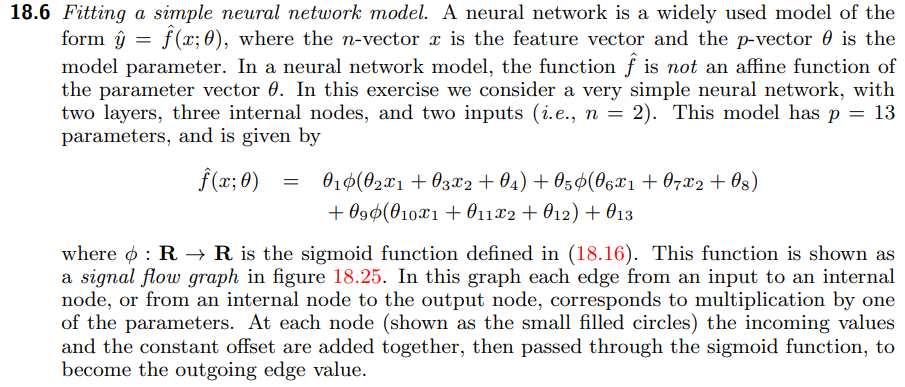
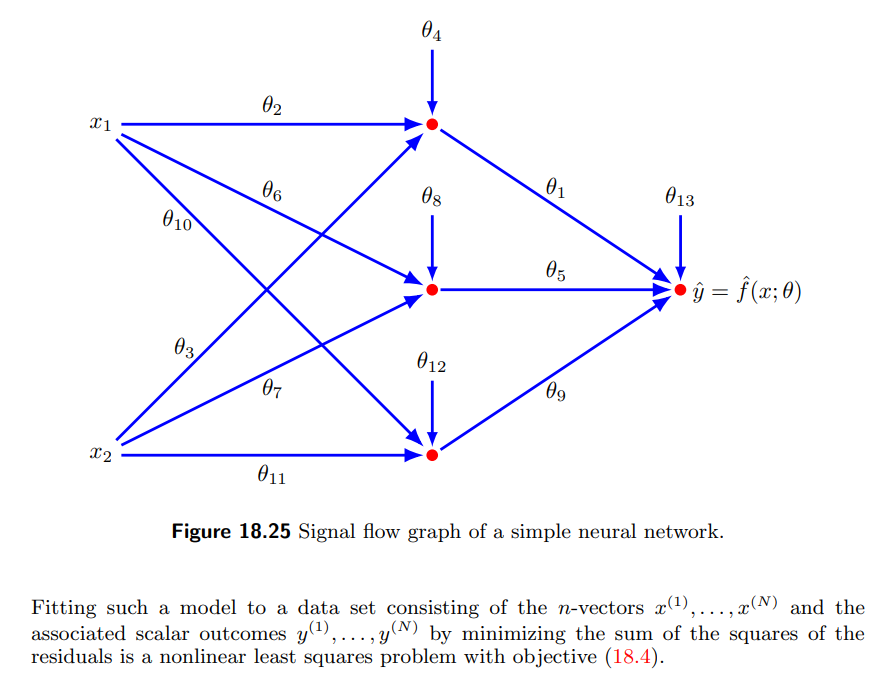

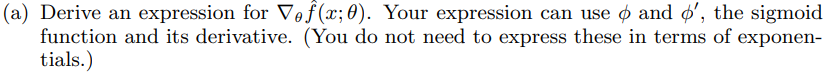

$$\hat{f}(x; \theta) = \theta_1 \phi(\theta_2 x_1 + \theta_3 x_2 + \theta_4) 
+ \theta_5 \phi(\theta_6 x_1 + \theta_7 x_2 + \theta_8) 
+ \theta_9 \phi(\theta_{10} x_1 + \theta_{11} x_2 + \theta_{12}) 
+ \theta_{13}$$

$$
\frac{\partial \hat{f}}{\partial \theta_1}
= 
\phi(\theta_2 x_1 + \theta_3 x_2 + \theta_4)
$$

Pela regra da cadeia
$$
\frac{\partial \hat{f}}{\partial \theta_2}
= 
\theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4)
\cdot
x_1
$$

$$
\frac{\partial \hat{f}}{\partial \theta_3}
= 
\theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4)
\cdot
x_2
$$

$$
\frac{\partial \hat{f}}{\partial \theta_4}
= 
\theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4)
$$

(processo semelhante para todos os outros)

$$
\nabla_\theta \hat{f}(x; \theta)
=
\begin{bmatrix}
    \phi(\theta_2 x_1 + \theta_3 x_2 + \theta_4) \\
    \theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4) x_1 \\
    \theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4) x_2 \\
    \theta_1 \phi'(\theta_2 x_1 + \theta_3 x_2 + \theta_4) \\
    \phi(\theta_6 x_1 + \theta_7 x_2 + \theta_8) \\
    \theta_5 \phi'(\theta_6 x_1 + \theta_7 x_2 + \theta_8) x_1 \\
    \theta_5 \phi'(\theta_6 x_1 + \theta_7 x_2 + \theta_8) x_2 \\
    \theta_5 \phi'(\theta_6 x_1 + \theta_7 x_2 + \theta_8) \\
    \phi(\theta_{10} x_1 + \theta_{11} x_2 + \theta_{12}) \\
    \theta_9 \phi'(\theta_{10} x_1 + \theta_{11} x_2 + \theta_{12}) x_1 \\
    \theta_9 \phi'(\theta_{10} x_1 + \theta_{11} x_2 + \theta_{12}) x_2 \\
    \theta_9 \phi'(\theta_{10} x_1 + \theta_{11} x_2 + \theta_{12})  \\
    1
\end{bmatrix},
$$

onde
$$
\phi(u) = \frac{e^u - e^{-u}}{e^u + e^{-u}}
\Rightarrow
\phi'(u) = \frac{4}{(e^x-e^{-x})^2}.
$$

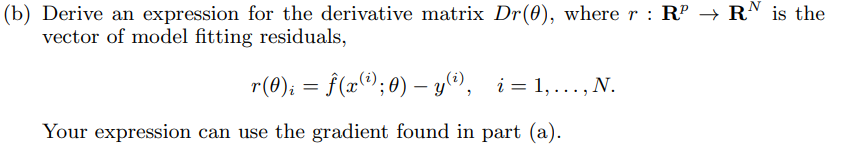

$$r(\theta)_i = \hat{f}(x^{(i)}\theta) - y^{(i)},
\ i = 1, \ldots, N$$

$$Dr(\theta)_i = \nabla_\theta \hat{f}(x^{(i)}\theta)^T,
\ i = 1, \ldots, N$$.

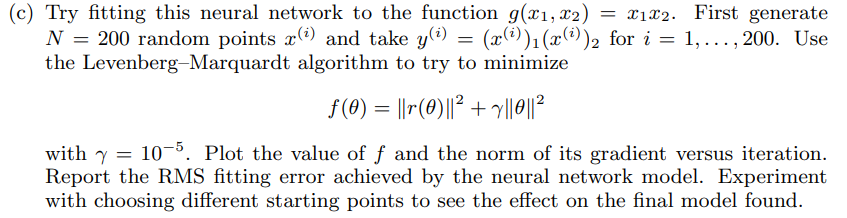

Antes de tudo, vamos relembrar o algoritmo de Levenberg-Marquardt.

In [124]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def lm(f, Df, x_ini, lam, tol=1e-6, k_max=100) -> np.ndarray:
    """
    Algoritmo de Levenberg-Marquardt para mínimos quadrados não-linear.

    Parâmetros:
    ----------
    f : function
        Função objetivo que retorna o vetor de resíduos. Deve ser vetorizada.
    Df : function
        Função que calcula a Jacobiana da função objetivo `f`.
    x_ini : numpy.ndarray
        Estimativa inicial para os parâmetros a serem otimizados.
    lam : float
        Parâmetro de amortecimento inicial que controla a magnitude da regularização.
    tol : float, opcional (default=1e-6)
        Critério de convergência com base na norma do gradiente.
    k_max : int, opcional (default=100)
        Número máximo de iterações.

    Retorna:
    -------
    xk : numpy.ndarray
        Vetor de parâmetros otimizados.
    """

    xk = x_ini.copy()

    k = 0
    while (np.linalg.norm(f(xk)) >= tol) and (np.linalg.norm(2 * Df(xk).T @ f(xk)) >= tol) and (k < k_max):
        J = Df(xk)
        H = J.T @ J
        g = J.T @ f(xk)

        p = np.linalg.inv(H + lam * np.eye(H.shape[0]))
        p = p @ g

        x_next = xk - p

        k += 1

        if np.linalg.norm(f(x_next)) < np.linalg.norm(f(xk)):
            lam = 0.8 * lam
            xk = x_next
            continue

        lam = 2 * lam
        # não atualiza xk

    return xk, k


In [126]:
x = np.linspace(0, 10, 300)
theta = np.array([2, -0.5, 7, -1])

In [127]:
f = lambda theta: theta[0] * np.exp(theta[1] * x) * np.cos(theta[2] * x + theta[3])

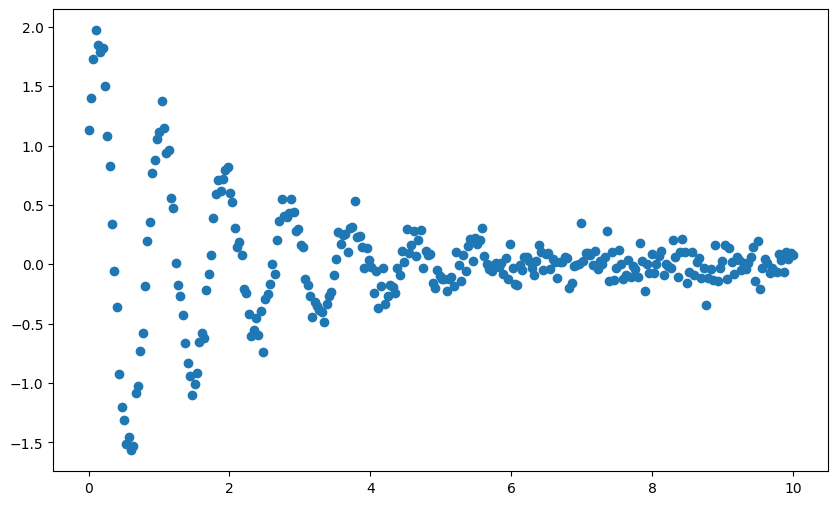

In [128]:
np.random.seed(42)
y = f(theta)
y_noisy = y + np.random.normal(0, 0.1, 300)

plt.figure(figsize=(10, 6))
plt.scatter(x, y_noisy)

In [129]:
Df = lambda theta: np.column_stack([
    (np.exp(theta[1] * x) * np.cos((theta[2] * x) + theta[3])),
    (theta[0] * x * np.exp(theta[1] * x) * np.cos((theta[2] * x) + theta[3])),
    -1.0 * (theta[0] * x * np.exp(theta[1] * x) * np.sin((theta[2] * x) + theta[3])),
    -1.0 * (theta[0] * np.exp(theta[1] * x) * np.sin((theta[2] * x) + theta[3])),
])

In [130]:
f_hat = lambda theta: f(theta) - y_noisy

In [ ]:
theta_ini = np.array([1, 0, 3, 0])

theta_opt, n_iter = lm(f_hat, Df, theta_ini, 1e-6)
theta_opt, n_iter

array([ 2.06634351, -0.51110936,  6.99012534, -0.98420722])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

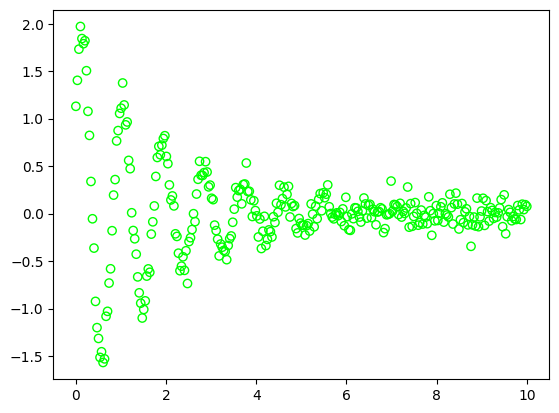

In [ ]:
plt.scatter(x, y_noisy, facecolors='none', edgecolors='#00ff00', label='Pontos perturbados da função original')
plt.plot(x, f(theta_opt), label='Regressão não linear')
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.legend(prop={'size': 14})
plt.show()